### Test case LVV-T1841 - Verify calculation of scientifically unusable pixel fraction

Verify that the DM system provides software to assess whether the maximum fraction of pixels scientifically unusable per sensor out of the total allowable fraction of sensors meeting this performance is less than **PixFrac = 1 percent**. 

### Test case LVV-T1847 - Verify calculation of sensor fraction with unusable pixels

Verify that the DM system provides software to assess whether the maximum allowable fraction of sensors with **PixFrac** > 1 percent scientifically unusable pixels is less than **SensorFraction = 15 percent**.

#### Discussion:

**Specification:** The maximum allowable fraction of sensors with **PixFrac > 1 percent** scientifically unusable pixels shall be **SensorFraction = 15 percent**.

To verify this, we will examine the pixels that are masked as defective in the defect masks, which identify pixels that have been flagged as problematic (i.e., not scientifically usable). The most basic study for this is to instantiate the defect masks that are applied to each exposure, and count how many pixels are included in those masks. This ignores "dynamic masks," which are set in response to features on the images (such as a saturated star, or the bleed trails from such objects).

In [1]:
# Check version of software
! echo $HOSTNAME
! eups list -s | grep lsst_distrib
! eups list -s | grep analysis_tools

jcarlin-nb


In [2]:
# Load needed python packages
from lsst.afw.cameraGeom import ReadoutCorner
from lsst.afw.image import ExposureF
from lsst.analysis.tools.actions.plot import FocalPlaneGeometryPlot
from lsst.daf.butler import Butler, DatasetNotFoundError
from lsst.ip.isr.isrFunctions import countMaskedPixels

import numpy as np
import matplotlib.pyplot as plt

import copy
from astropy.table import Table

Set up some parameters to examine LSSTCam defect masks.

In [3]:
# PARAMETERS:
# Instrument to consider for analysis:
INSTRUMENT = "LSSTCam"
# Repository containing our data.
REPO = "/repo/main"
# Collection containing processed exposures to use for metadata scan.
collection = "LSSTCam/calib"
# Dataset type to scan.
dataset_type = "defects"

# Requirement
PIXFRAC = 0.01
SENSORFRAC = 0.15

We need the camera data product for a number of things. Instantiate the butler and find this.

In [4]:
butler = Butler(REPO)
camera = butler.get("camera", instrument=INSTRUMENT,
                    collections=f"{INSTRUMENT}/calib")

Loop over the detectors in the camera, retrieving the defects mask for each one, and counting the number of masked pixels. Then calculation the fraction of pixels that are marked as defective, and set a flag for the detector denoting whether it is within the specification for **PixFrac**.

In [5]:
N_out_of_spec = 0
N_detectors = 0
# Output catalog of results:
catalog = {"instrument": [],
           "detectorId": [],
           "detectorName": [],
           "defectPixels": [],
           "totalPixels": [],
           "defectFraction": [],
           "withinSpec": []}
    
for detector in camera:
    N_detectors += 1
    # Instantiate an empty exposure:
    exp = ExposureF(detector.getBBox())

    # Retrieve defects:
    try:
        defects = butler.get("defects", instrument=INSTRUMENT, detector=detector.getId(), collections="LSSTCam/calib")
    except:
        # Defects aren't generated for non-science detectors.
        break

    # Perform masking
    defects.maskPixels(exp)

    # Confirm mask value is either 0 or 1:
    if set(np.unique(exp.mask.array.ravel())) != {0, 1}:
        raise RuntimeError("Mask has unexpected values.")

    # Sum defect pixels
    defect_count = np.sum(exp.mask.array.ravel())

    # Get total area
    area = detector.getBBox().getArea()

    # Do check:
    fraction = defect_count / area
    within_spec = True
    if fraction > PIXFRAC:
        within_spec = False
        N_out_of_spec += 1
    # Save results
    catalog['instrument'].append(INSTRUMENT)
    catalog['detectorId'].append(detector.getId())
    catalog['detectorName'].append(detector.getName())
    catalog['defectPixels'].append(defect_count)
    catalog['totalPixels'].append(area)
    catalog['defectFraction'].append(fraction)
    catalog['withinSpec'].append(within_spec)

outCat = Table(catalog)
outCat.write("./lvv_isr_detector_defects.fits", overwrite=True)

Calculate the fraction of sensors that do not meet the **PixFrac** specification. Compare this value to the **sensorFrac** specification, and report whether it passes or fails to meet the requirement.

In [6]:
sensorFracValue = {True: "passed", False: "failed"}
sensorFracTestResult = True
if (N_out_of_spec / (1.0 * N_detectors)) > SENSORFRAC:
    sensorFracTestResult = False
print(f"There are {N_out_of_spec} out-of-spec detectors out of {N_detectors} total, "
      f"for a measured sensorFrac of {N_out_of_spec / N_detectors :.3f}.")
print(f"This requirement has {sensorFracValue[sensorFracTestResult]}.")

There are 8 out-of-spec detectors out of 190 total, for a measured sensorFrac of 0.042.
This requirement has passed.


We've now scanned all exposures to get our catalog, so we can extract the values for each amplifier.
The stats are only calculated at the amplifier level, so we'll need to create our own detector level statistics (using the bounding box of the detector from the camera).

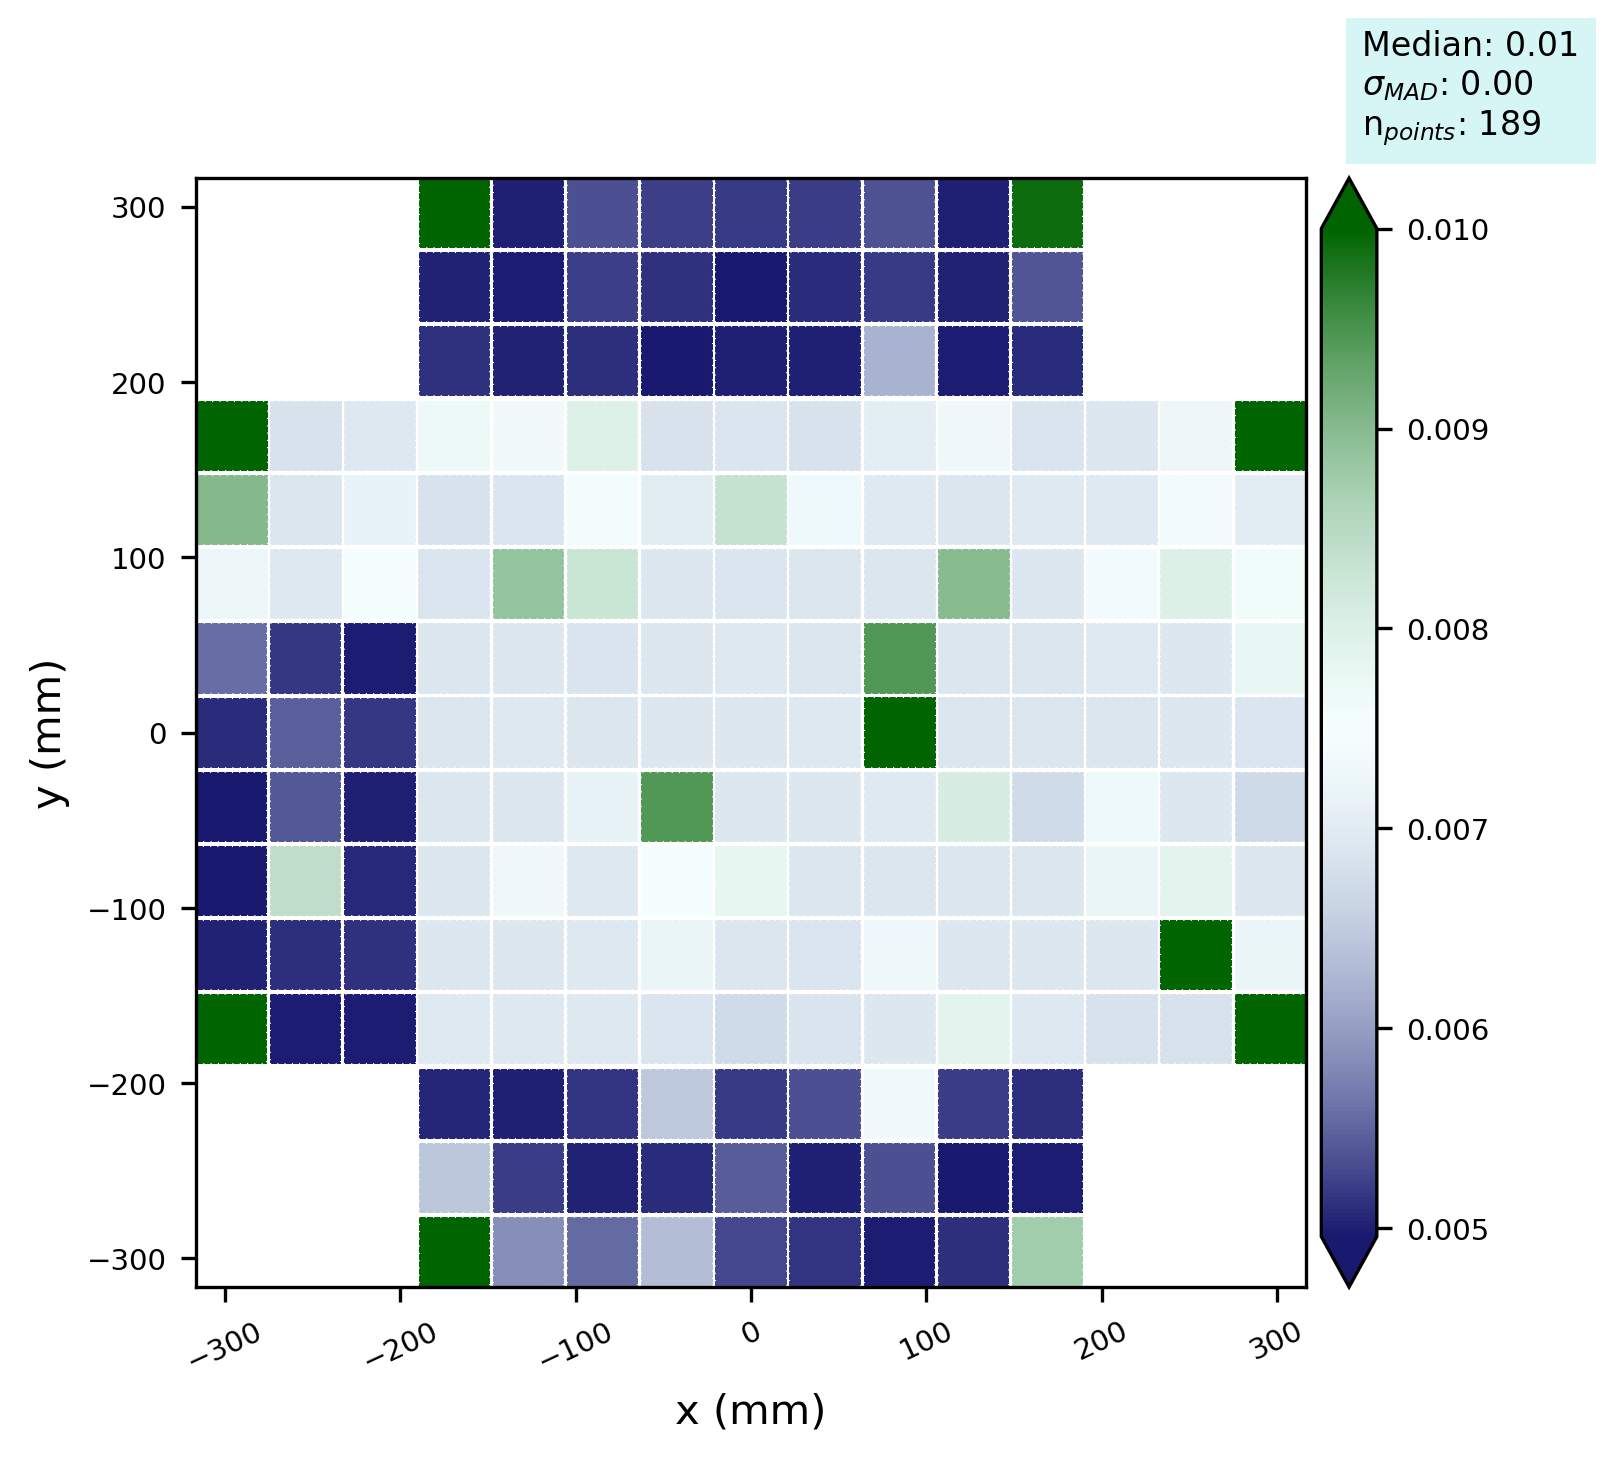

In [7]:
# Make plots.  This function expects the `detector` column, and we must define the `z`.
data = {'detector': catalog['detectorId'],
        'z': catalog['defectFraction'],
       }
# Plot by-detector of the fraction of pixels in that amplifier that are BAD:
by_amplifier = FocalPlaneGeometryPlot(level='detector', 
                                      plotMin=0.0, 
                                      plotMax=PIXFRAC).makePlot(data=Table(data), 
                                                                camera=camera, 
                                                                plotInfo={})

### Results

We have demonstrated that the fraction of scientifically unusable pixels is less than **PixFrac=1%** for all but 4% of the detectors, which is well below the required **SensorFraction=15%** threshold. Thus the results of both of these tests are "Pass".